****IMPORTING LIBRARIES****

In [1]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model, load_model # for assembling a Neural Network model
from keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout # for adding layers
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU # for adding layers
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization

# Data manipulation
import tensorflow as tf
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version



# Visualization
import matplotlib
import matplotlib.pyplot as plt # for data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version

# Other utilities
import sys
import os
import cv2


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Tensorflow/Keras: 2.12.0
numpy: 1.23.5
matplotlib: 3.7.2
graphviz: 0.20.1


****LOAD DATASET-IMAGES OF HUMAN FACES******

In [2]:
# The dataset contains images of human faces obtained fom kaggle.the images are loaded into numpy array 
# and resized to 112*112 to meet teh requirements of our model. 
folder_path =  '/kaggle/input/person-face-sketches/train/photos'
dataset=[]
for filename in os.listdir(folder_path):
  file_path=os.path.join(folder_path,filename)
  img=cv2.imread(file_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(112,112))
  img=(img-img.min())/(255-img.min())  
  img= img*2-1
  dataset.append(img)
  if len(dataset)==19000:
    break
dataset=np.array(dataset)

In [3]:

dataset.shape

(19000, 112, 112, 3)

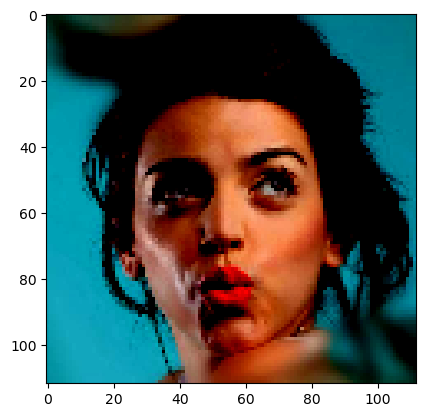

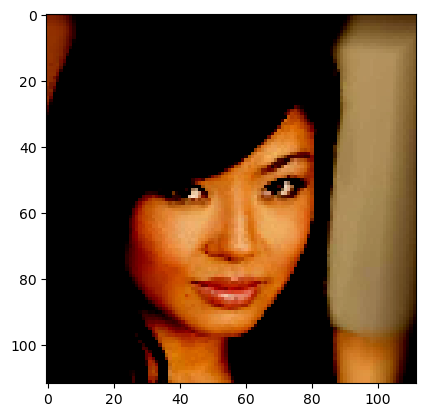

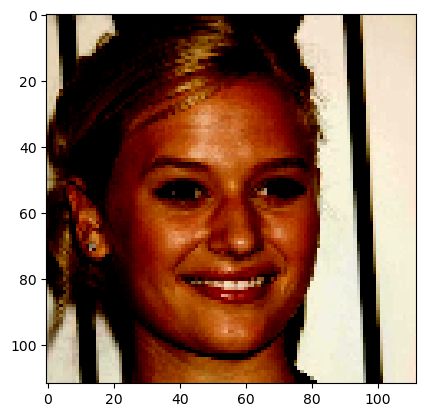

In [4]:
#displaying a few images
plt.imshow(dataset[4102])
plt.show()
plt.imshow(dataset[3389])
plt.show()
plt.imshow(dataset[26])
plt.show()

In [5]:
# below are the functions used to prepae the proper dataset that can be fed into the model for
# training real samples are given a label of 1 and fake samples are given a label of 0.
def real_samples(dataset, n):

    # Create a random list of indices
    indx = np.random.randint(0, dataset.shape[0], n)

    # Select real data samples (images ) using the list of random indeces from above
    X= dataset[indx]

    # Class labels
    y = np.ones((n, 1))
    return [X], y


def latent_vector(latent_dim, n):

    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)

    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return [latent_input]


def fake_samples(generator, latent_dim, n):

    # Draw latent variables
    latent_output= latent_vector(latent_dim, n)

    # Predict outputs (i.e., generate fake samples)
    X = generator.predict([latent_output])

    # Create class labels
    y = np.zeros((n, 1))
    return [X], y

***MODEL DEFINITION***

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Latent-Input-Laye  [(None, 100)]            0         
 r (InputLayer)                                                  
                                                                 
 Generator-Foundation-Layer   (None, 12544)            1266944   
 (Dense)                                                         
                                                                 
 Generator-Foundation-Layer-  (None, 12544)            0         
 Activation-1 (ReLU)                                             
                                                                 
 Generator-Foundation-Layer-  (None, 7, 7, 256)        0         
 Reshape-1 (Reshape)                                             
                                                                 
 Generator-Hidden-Layer-1 (C  (None, 14, 14, 128)      29

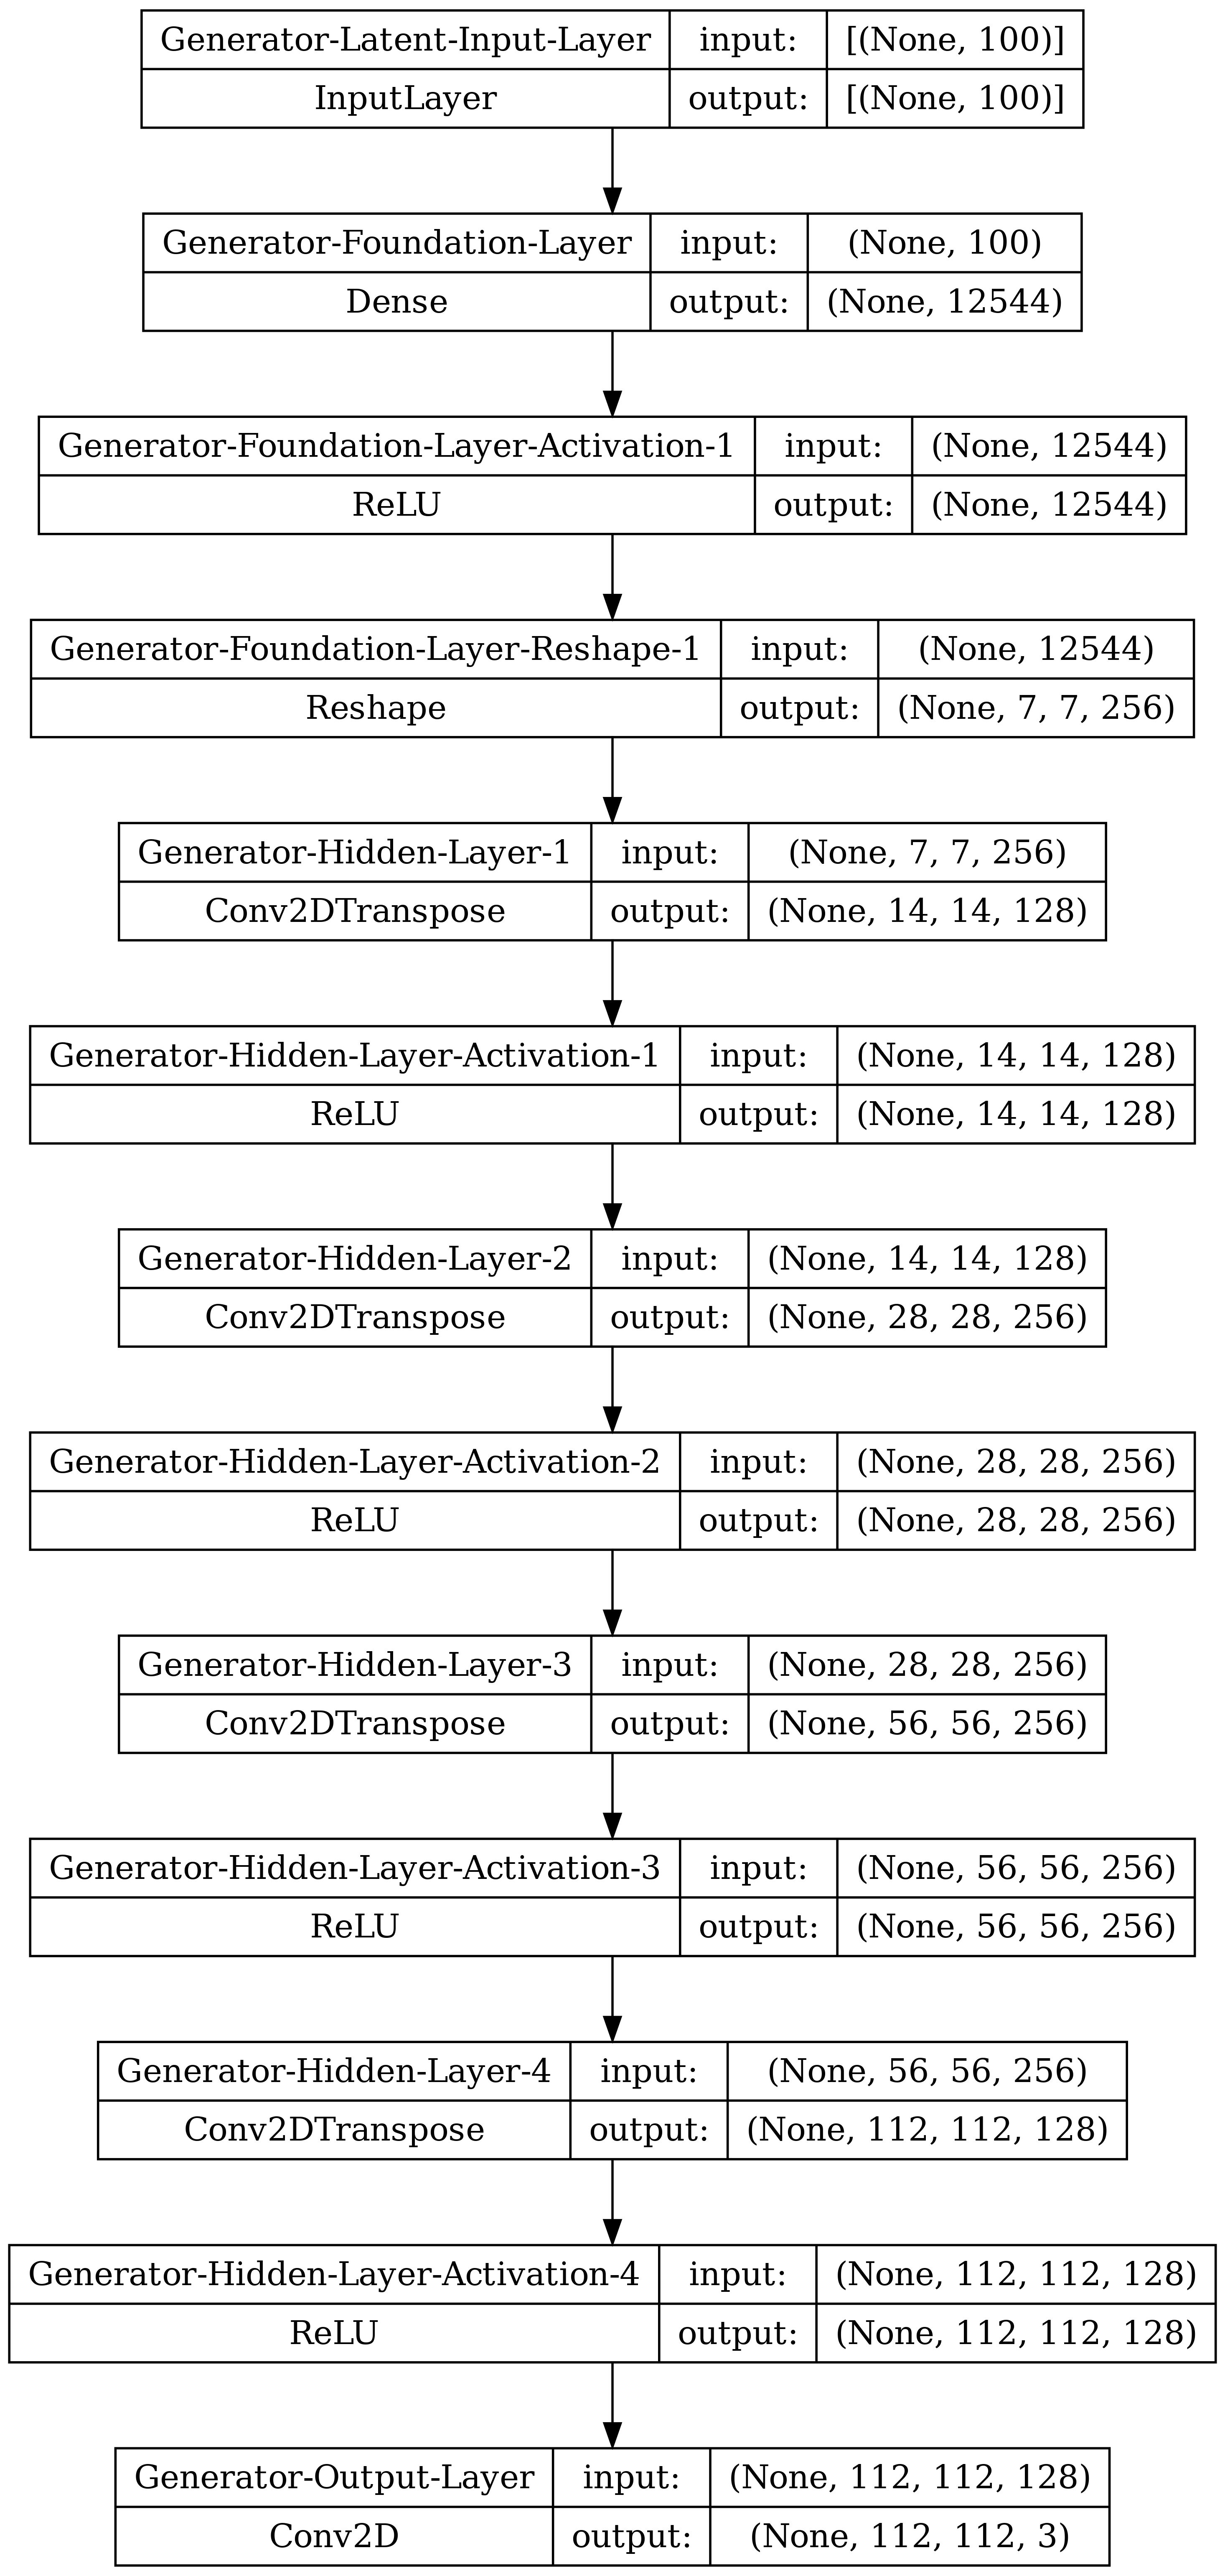

In [6]:
# below function defines the generator model .the generator model takes in an input 
# 2d noise vector of size 7*7 and outputs an iage of size 112*112 
def generator(latent_dim, in_shape=(7,7,1)):

    # Generator Inputs (latent vector)
    in_latent = Input(shape=latent_dim, name='Generator-Latent-Input-Layer')

    # Image Foundation
    n_nodes = 7 * 7 * 256 # number of nodes in the initial layer
    g = Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
    g = ReLU(name='Generator-Foundation-Layer-Activation-1')(g)
    g = Reshape((in_shape[0], in_shape[1], 256), name='Generator-Foundation-Layer-Reshape-1')(g)

    # Combine both inputs so it has two channels

    # Hidden Layer 1
    g = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-1')(g)

    # Hidden Layer 2
    g = Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-2')(g)

    g = Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-3')(g)

    g = Conv2DTranspose(filters=128, kernel_size=(7,7), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-4')(g)

    # Output Layer (Note, we use only one filter because we have a greysclae image. Color image would have three
    output_layer = Conv2D(filters=3, kernel_size=(7,7), activation='tanh', padding='same', name='Generator-Output-Layer')(g)

    # Define model
    model = Model([in_latent], output_layer, name='Generator')
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400,to_file='/kaggle/working/generator_model.png')


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Image-Input-L  [(None, 112, 112, 3)]    0         
 ayer (InputLayer)                                               
                                                                 
 Discriminator-Hidden-Layer-  (None, 56, 56, 128)      3584      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 56, 56, 128)      0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 28, 28, 256)      819456    
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 28, 28, 256)    

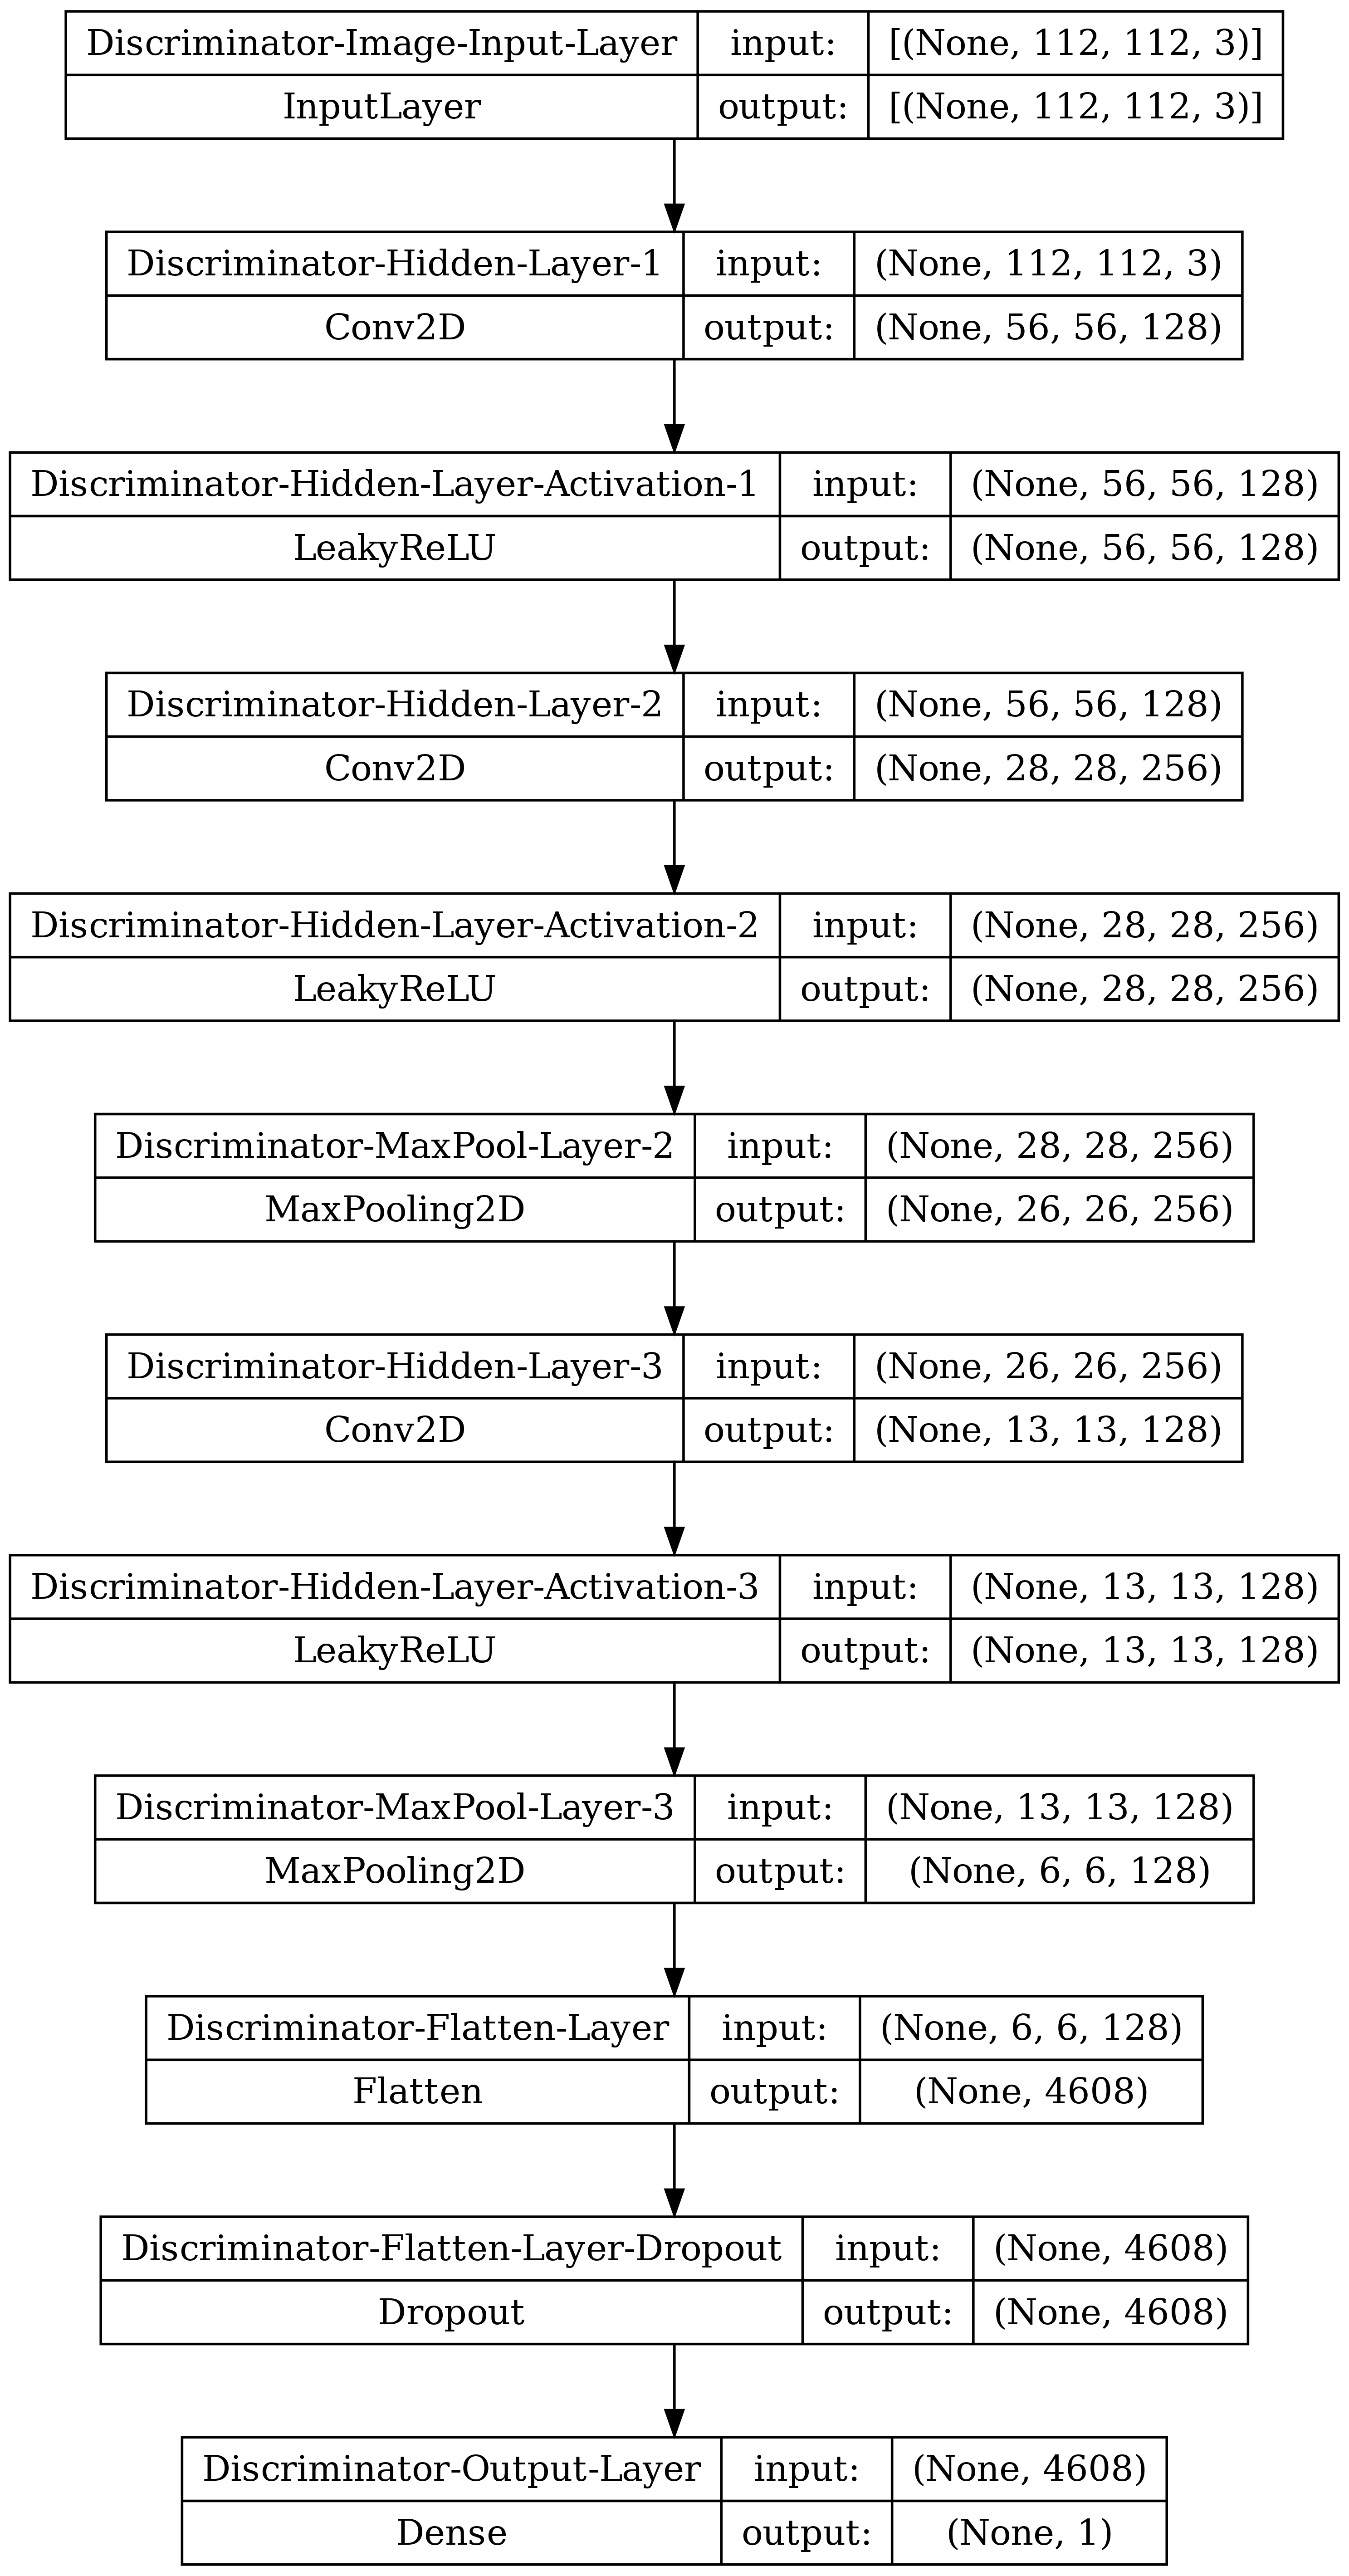

In [7]:
#b elow function  defines discriminator model that tries to distinguish generated iamges(fake)
# and real images.the discriminator   takes in real and fake images as input and outputs 1 if 
# it is real and 0 otherwise. 
def discriminator(in_shape=(112,112,3), n_cats=1):

    
    # Image Inputs
    in_image = Input(shape=in_shape, name='Discriminator-Image-Input-Layer')

    # Hidden Layer 1
    h = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-1')(in_image)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1')(h)

    # Hidden Layer 2
    h = Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-2')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='valid', name='Discriminator-MaxPool-Layer-2')(h) # Max Pool

    h = Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-3')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-MaxPool-Layer-3')(h) # Max Pool


    # Flatten and Output Layers
    h = Flatten(name='Discriminator-Flatten-Layer')(h) # Flatten the shape
    h = Dropout(0.2, name='Discriminator-Flatten-Layer-Dropout')(h) # Randomly drop some connections for better generalization

    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h) # Output Layer

    # Define model
    model = Model([in_image], output_layer, name='Discriminator')

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002,beta_1=0.49), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400,to_file='/kaggle/working/discriminator_model.png')


Model: "cDCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Latent-Input-Laye  [(None, 100)]            0         
 r (InputLayer)                                                  
                                                                 
 Generator-Foundation-Layer   (None, 12544)            1266944   
 (Dense)                                                         
                                                                 
 Generator-Foundation-Layer-  (None, 12544)            0         
 Activation-1 (ReLU)                                             
                                                                 
 Generator-Foundation-Layer-  (None, 7, 7, 256)        0         
 Reshape-1 (Reshape)                                             
                                                                 
 Generator-Hidden-Layer-1 (C  (None, 14, 14, 128)      29504

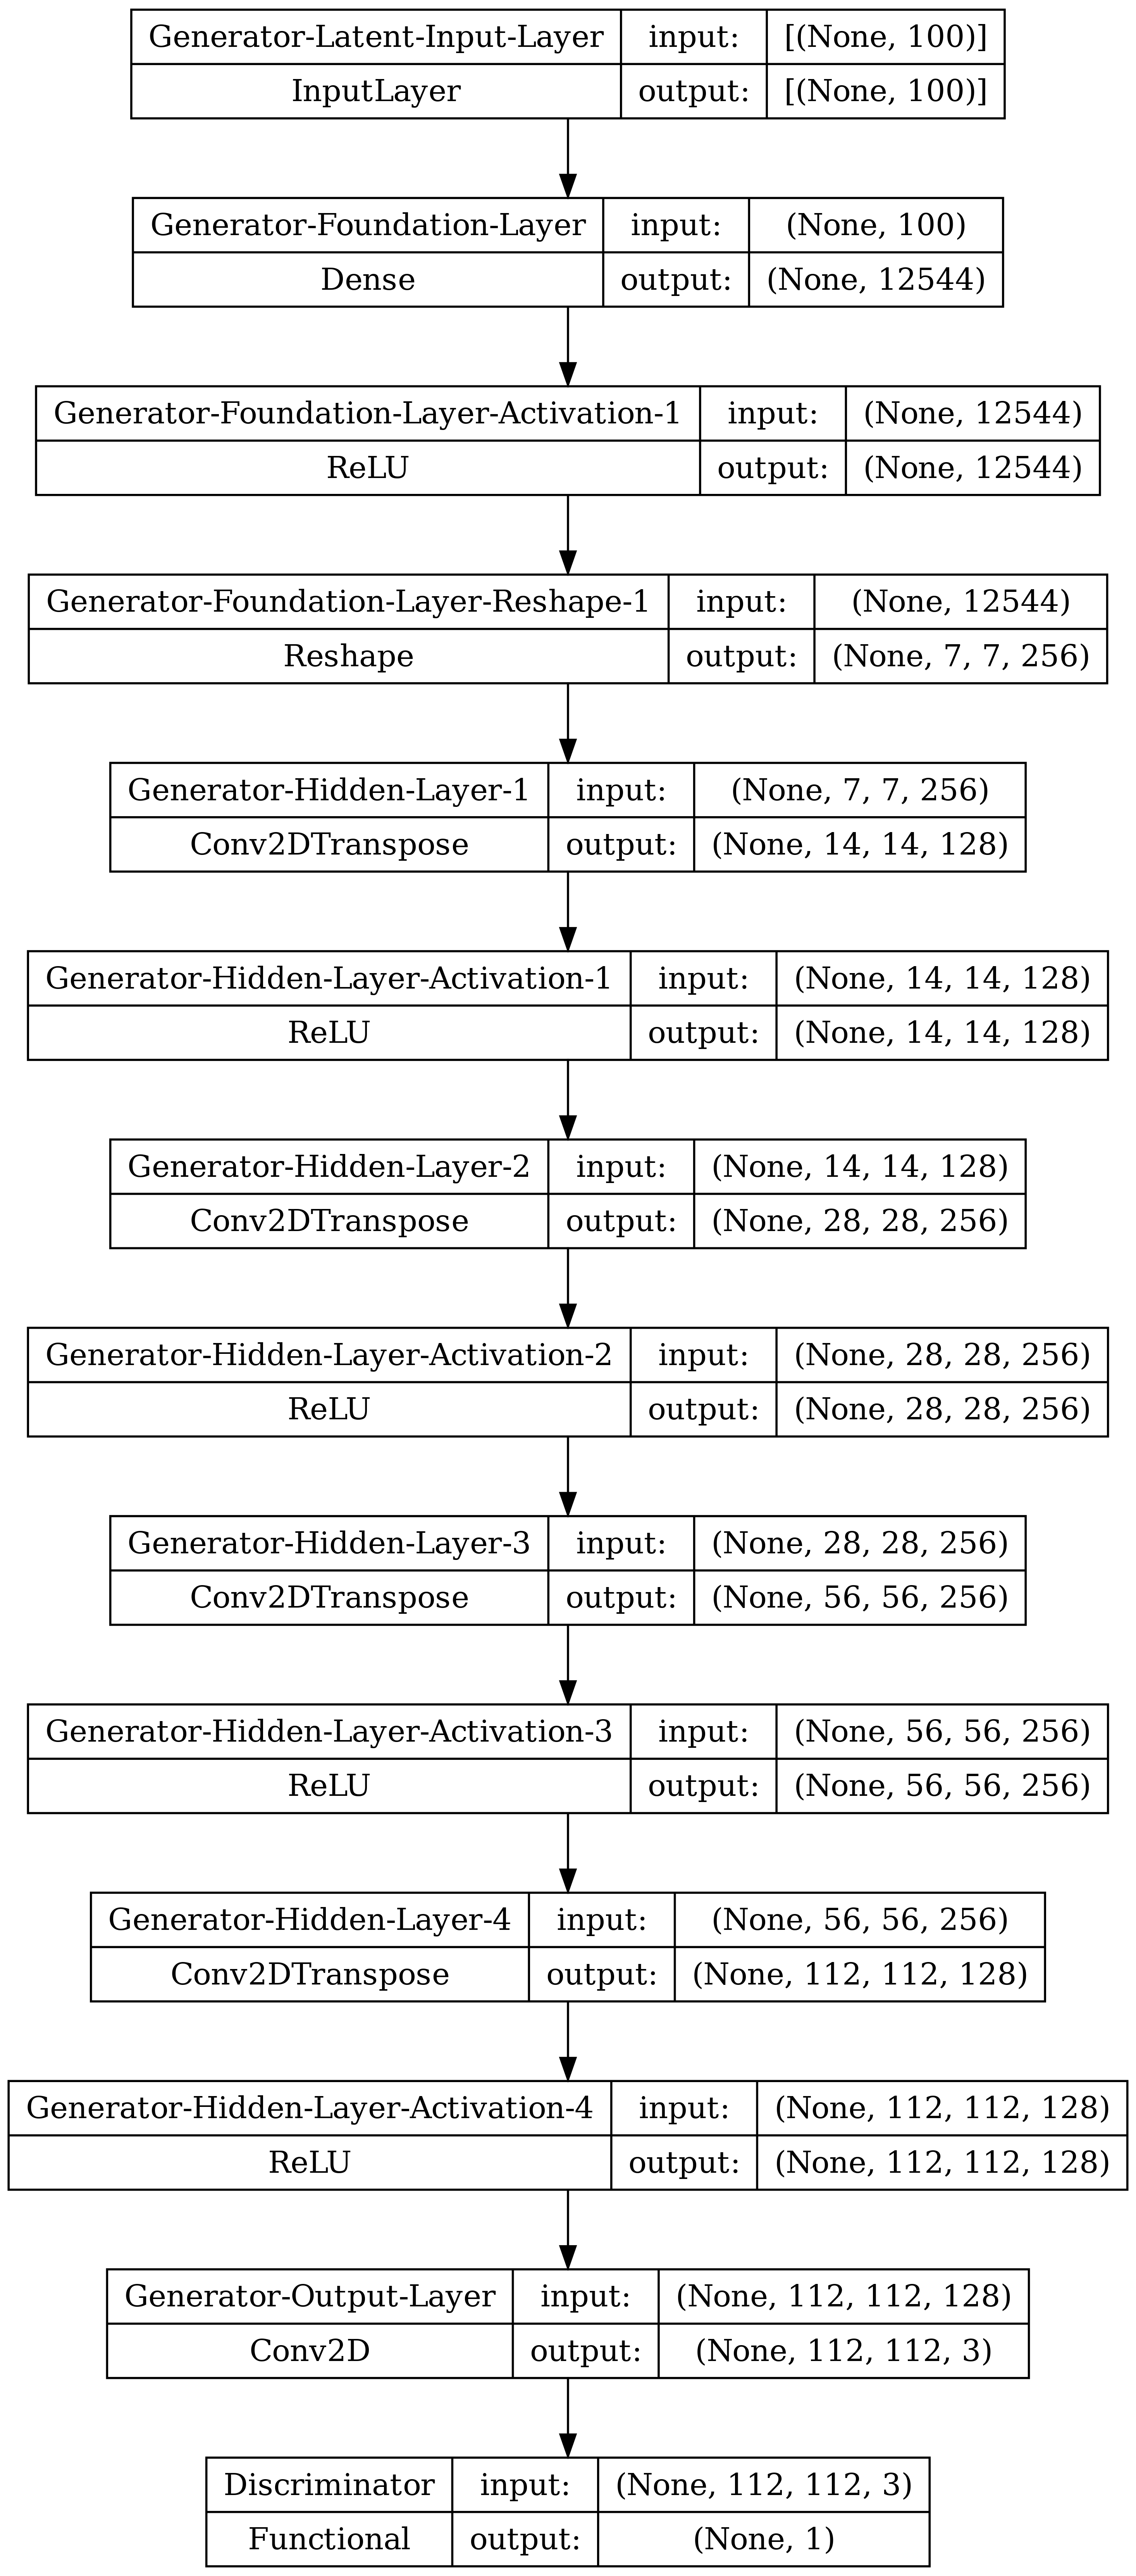

In [8]:
# the generator adn discriminator are combined to form DCGAN model.
def DCGAN(generator, discriminator):

    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False

    # Get Generator inputs / outputs
    gen_latent= generator.input # Latent and label inputs from the generator
    gen_output = generator.output # Generator output image

    # Connect image and label from the generator to use as input into the discriminator
    gan_output = discriminator([gen_output])

    # Define GAN model
    model = Model([gen_latent], gan_output, name="cDCGAN")

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002,beta_1=0.49))
    return model

# Instantiate
gan_model = DCGAN(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400 ,to_file='/kaggle/working/DCGAN_model.png')


In [9]:
# below funcion show_fakes is used to display the generated images after each epoch during training
def show_fakes(generator, latent_dim, n=10):

    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)

    # Rescale from [-1, 1] to [0, 1]
    X_tst = (x_fake[0])

    # Display fake (generated) images
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(X_tst[k], cmap='gray')
            axs[i,j].axis('off')
            k=k+1
    plt.show()

In [10]:

#code for training of DCGAN model
disc_loss_real=[]
disc_loss_fake=[]
gen_loss=[]
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256, n_eval=200):
    # Number of batches to use per each epoch
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)

    # We will manually enumare epochs
    for i in range(n_epochs):

        # Enumerate batches over the training set
        for j in range(batch_per_epoch):

        # Discriminator training
            # Prep real samples
            [x_real], y_real = real_samples(dataset, half_batch)
            # Train discriminator with real samples
            discriminator_loss1, _ = d_model.train_on_batch([x_real], y_real)
            disc_loss_real.append(discriminator_loss1)

            # Prep fake (generated) samples
            [x_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            # Train discriminator with fake samples
            discriminator_loss2, _ = d_model.train_on_batch([x_fake], y_fake)
            disc_loss_fake.append(discriminator_loss2)


        # Generator training
            # Get values from the latent space to be used as inputs for the generator
            [latent_input] = latent_vector(latent_dim, n_batch)
            # While we are generating fake samples,
            # we want GAN generator model to create examples that resemble the real ones,
            # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
            y_gan = np.ones((n_batch, 1))

            # Train the generator via a composite GAN model
            generator_loss = gan_model.train_on_batch([latent_input], y_gan)
            gen_loss.append(generator_loss)

        # Summarize training progress and loss
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' %
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                show_fakes(g_model, latent_dim)

***DCGAN MODEL TRAINING***

 batch_per_epoch:  74
4/4 [==============================] - 1s 25ms/step
Epoch: 1, Batch: 1/74, D_Loss_Real=0.678, D_Loss_Fake=0.697 Gen_Loss=0.690
1/1 [==============================] - 0s 367ms/step


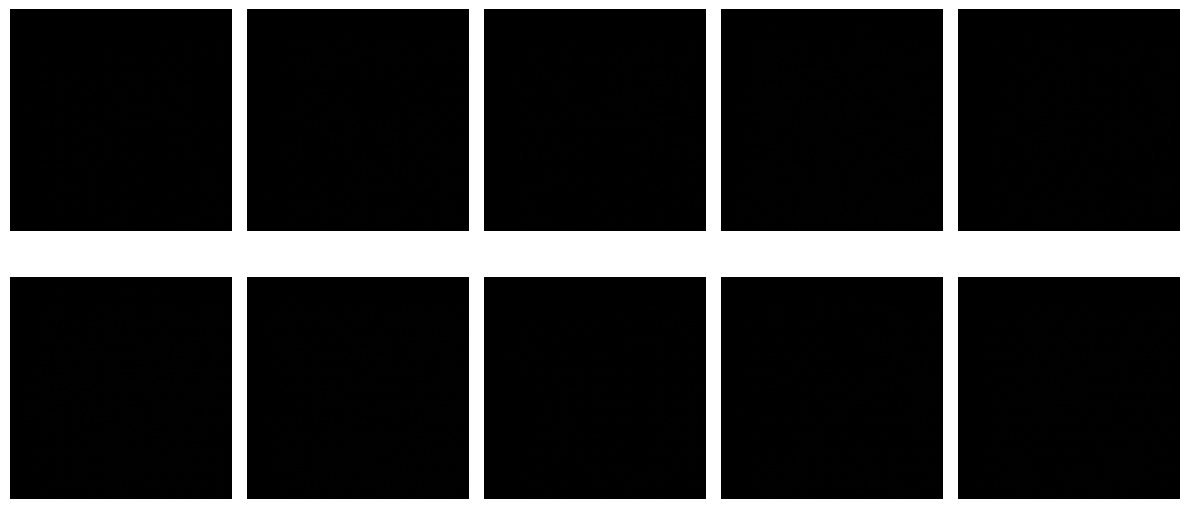

4/4 [==============================] - 0s 30ms/step
Epoch: 2, Batch: 1/74, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=6.567
1/1 [==============================] - 0s 18ms/step


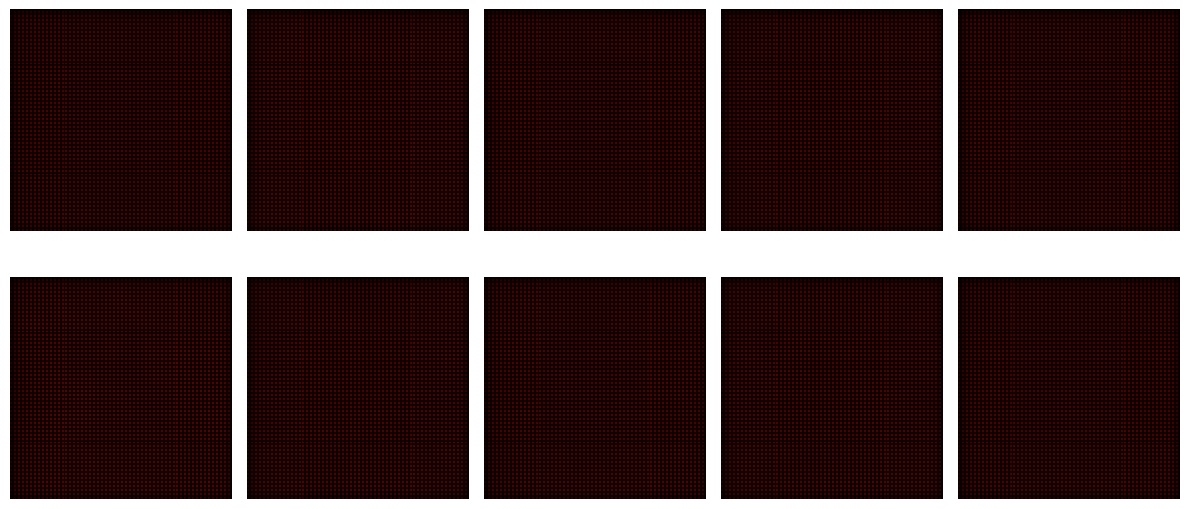

4/4 [==============================] - 0s 30ms/step
Epoch: 3, Batch: 1/74, D_Loss_Real=0.000, D_Loss_Fake=0.007 Gen_Loss=5.411
1/1 [==============================] - 0s 18ms/step


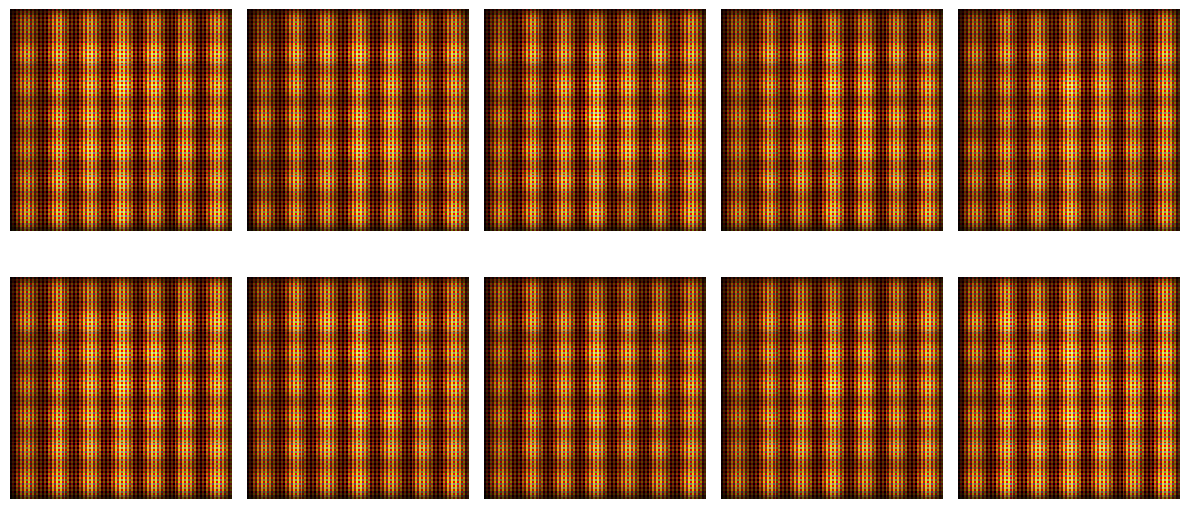

4/4 [==============================] - 0s 30ms/step
Epoch: 4, Batch: 1/74, D_Loss_Real=0.164, D_Loss_Fake=0.211 Gen_Loss=4.284
1/1 [==============================] - 0s 19ms/step


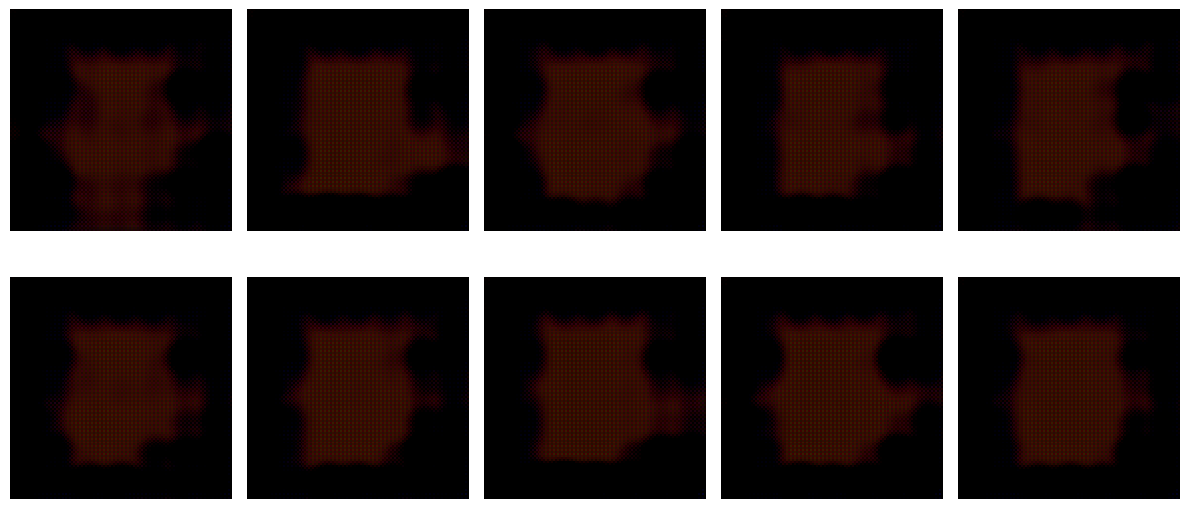

4/4 [==============================] - 0s 30ms/step
Epoch: 5, Batch: 1/74, D_Loss_Real=0.252, D_Loss_Fake=0.306 Gen_Loss=3.360
1/1 [==============================] - 0s 19ms/step


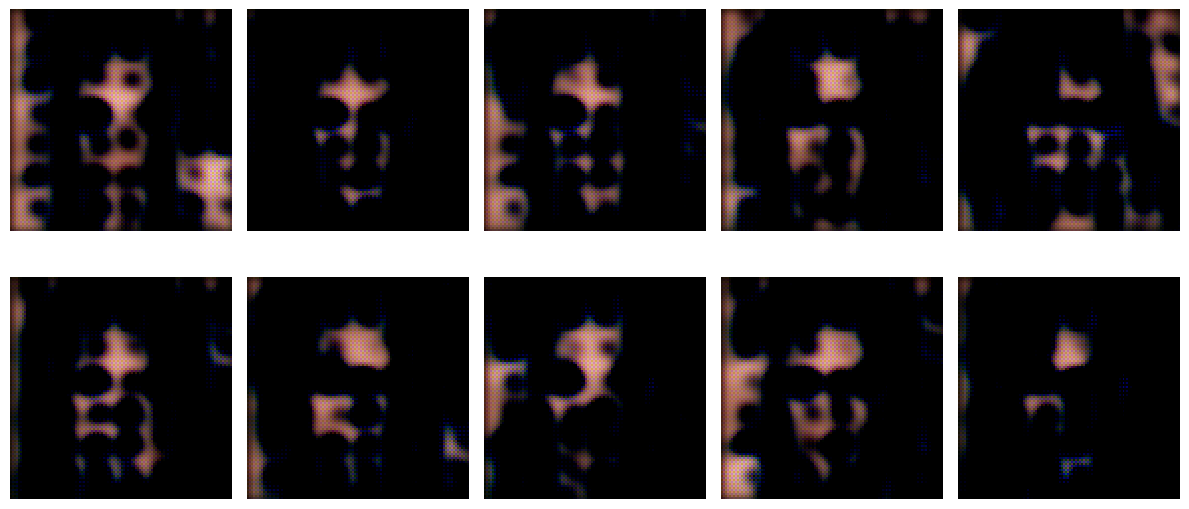

4/4 [==============================] - 0s 30ms/step
Epoch: 6, Batch: 1/74, D_Loss_Real=0.275, D_Loss_Fake=0.218 Gen_Loss=2.803
1/1 [==============================] - 0s 18ms/step


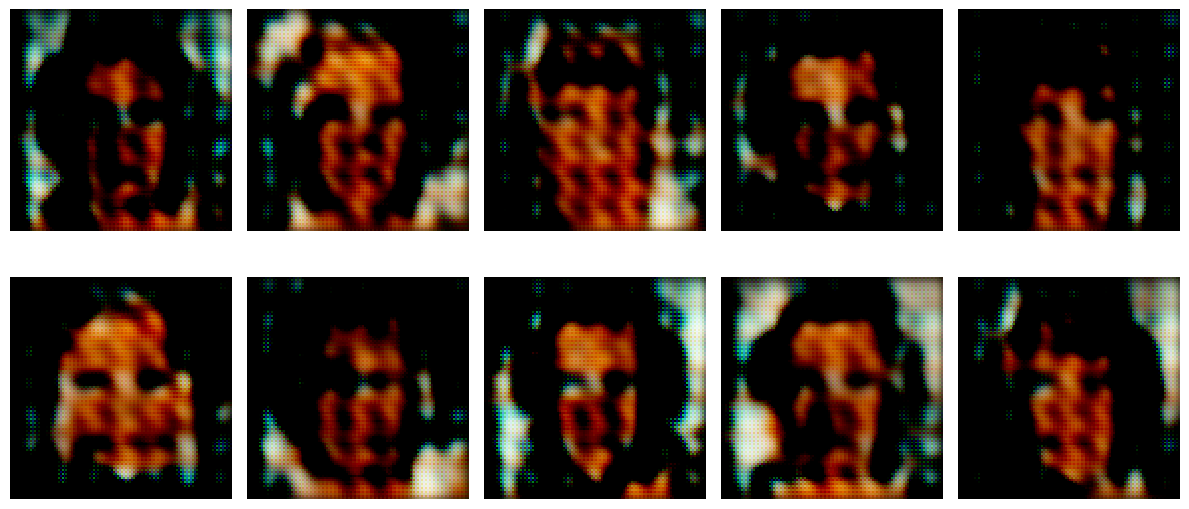

4/4 [==============================] - 0s 30ms/step
Epoch: 7, Batch: 1/74, D_Loss_Real=0.331, D_Loss_Fake=0.385 Gen_Loss=2.567
1/1 [==============================] - 0s 18ms/step


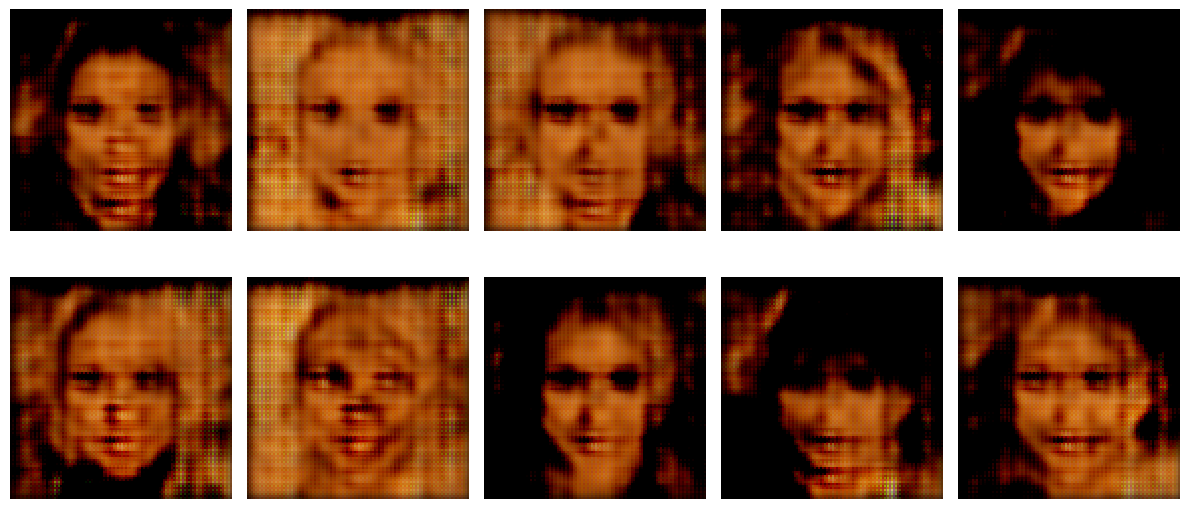

4/4 [==============================] - 0s 30ms/step
Epoch: 8, Batch: 1/74, D_Loss_Real=0.207, D_Loss_Fake=0.315 Gen_Loss=3.186
1/1 [==============================] - 0s 19ms/step


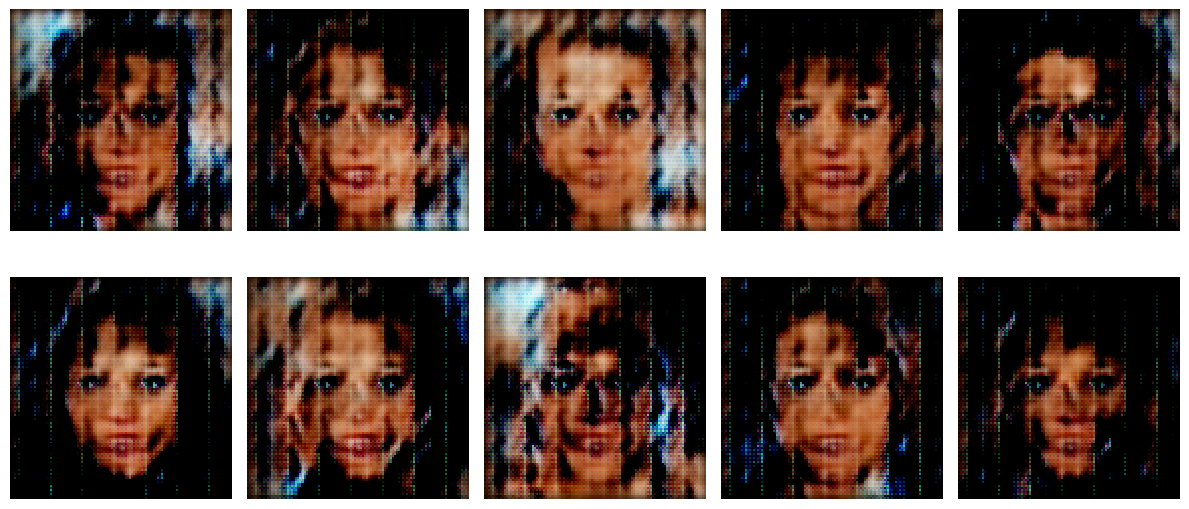

4/4 [==============================] - 0s 30ms/step
Epoch: 9, Batch: 1/74, D_Loss_Real=0.358, D_Loss_Fake=0.471 Gen_Loss=2.026
1/1 [==============================] - 0s 18ms/step


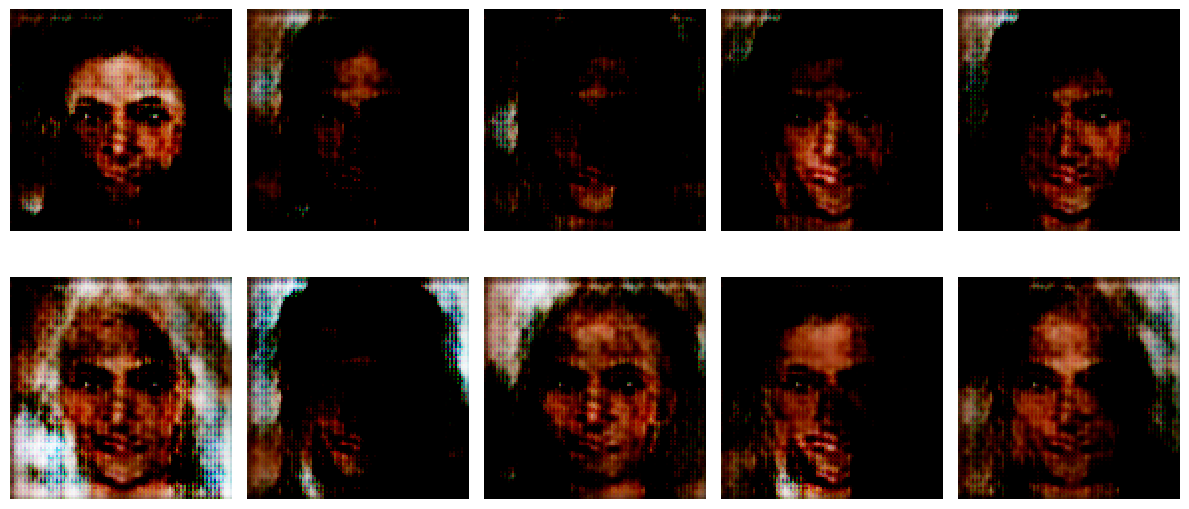

4/4 [==============================] - 0s 30ms/step
Epoch: 10, Batch: 1/74, D_Loss_Real=0.357, D_Loss_Fake=0.458 Gen_Loss=1.845
1/1 [==============================] - 0s 19ms/step


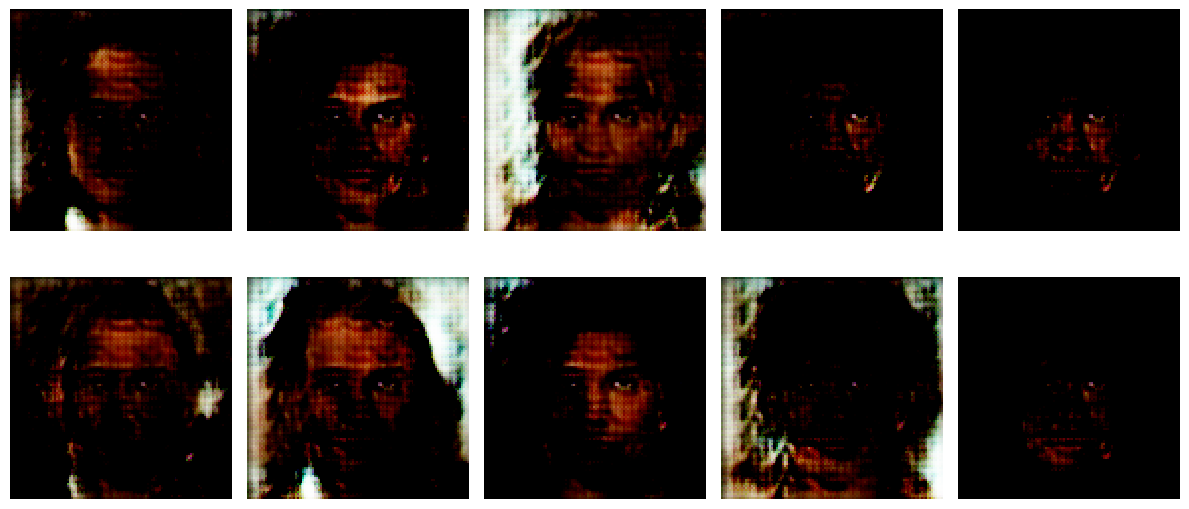

4/4 [==============================] - 0s 30ms/step
Epoch: 11, Batch: 1/74, D_Loss_Real=0.284, D_Loss_Fake=0.480 Gen_Loss=2.073
1/1 [==============================] - 0s 18ms/step


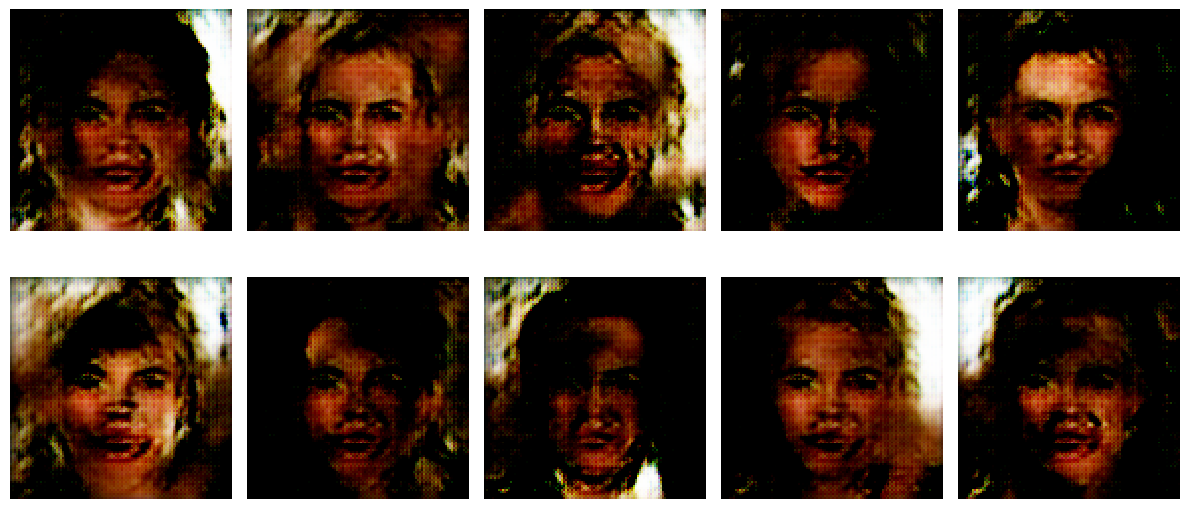

4/4 [==============================] - 0s 30ms/step
Epoch: 12, Batch: 1/74, D_Loss_Real=0.561, D_Loss_Fake=0.688 Gen_Loss=2.466
1/1 [==============================] - 0s 18ms/step


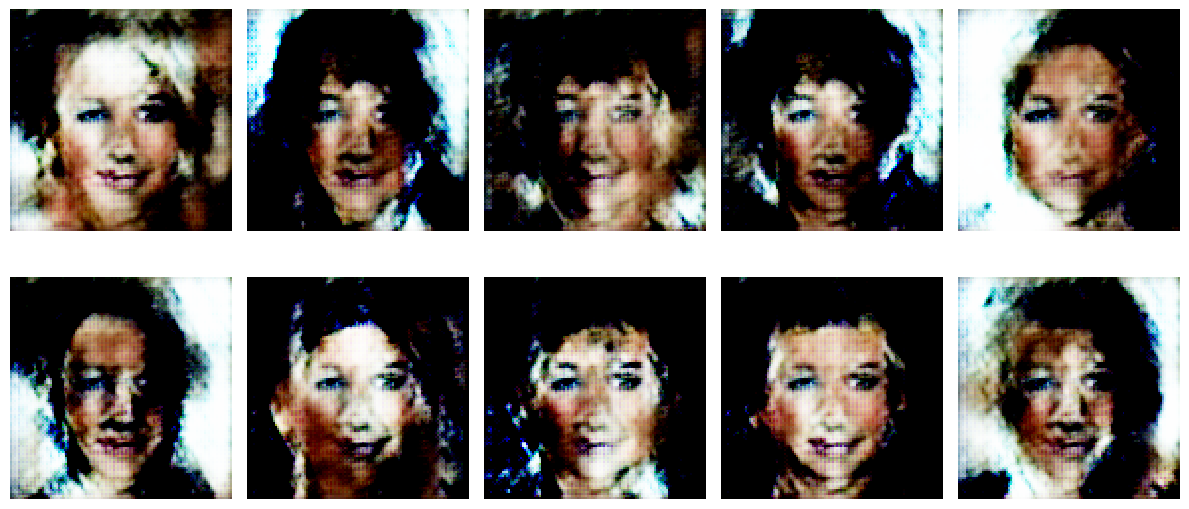

4/4 [==============================] - 0s 30ms/step
Epoch: 13, Batch: 1/74, D_Loss_Real=0.391, D_Loss_Fake=0.392 Gen_Loss=2.383
1/1 [==============================] - 0s 19ms/step


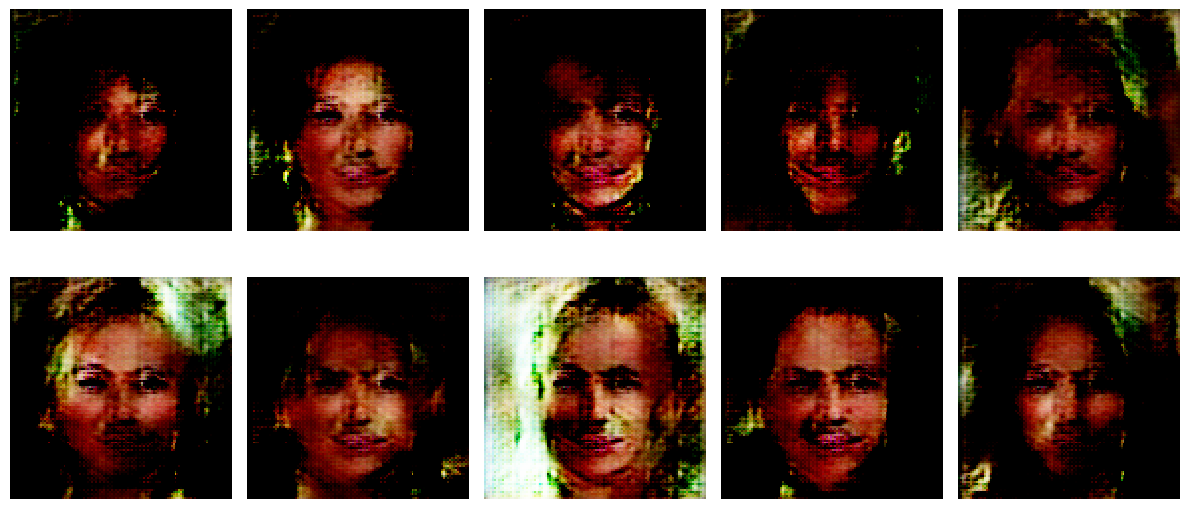

4/4 [==============================] - 0s 30ms/step
Epoch: 14, Batch: 1/74, D_Loss_Real=0.492, D_Loss_Fake=0.546 Gen_Loss=2.195
1/1 [==============================] - 0s 18ms/step


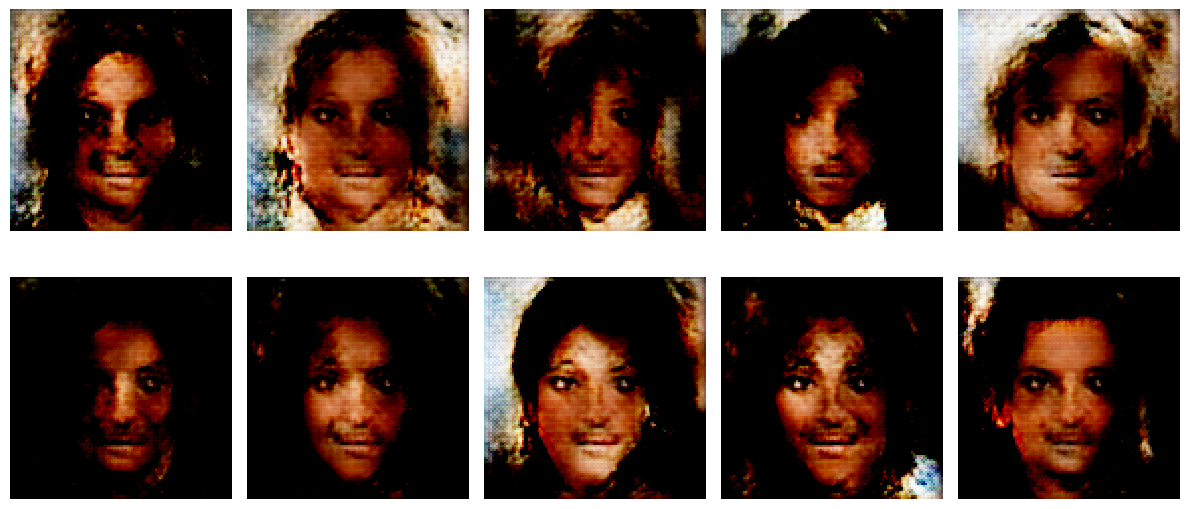

4/4 [==============================] - 0s 30ms/step
Epoch: 15, Batch: 1/74, D_Loss_Real=0.420, D_Loss_Fake=0.401 Gen_Loss=2.013
1/1 [==============================] - 0s 19ms/step


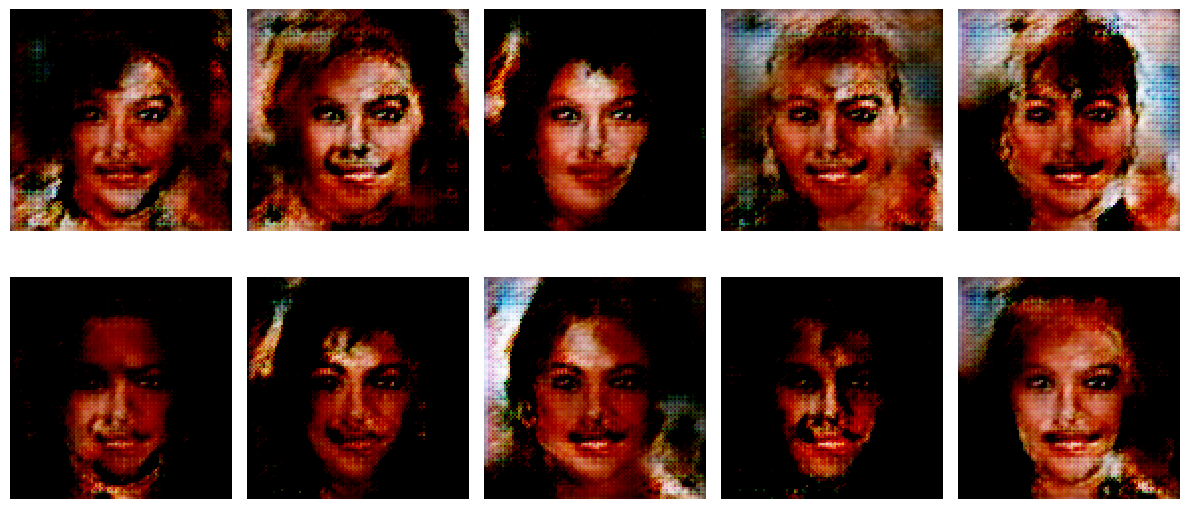

4/4 [==============================] - 0s 31ms/step
Epoch: 16, Batch: 1/74, D_Loss_Real=0.483, D_Loss_Fake=0.438 Gen_Loss=2.352
1/1 [==============================] - 0s 18ms/step


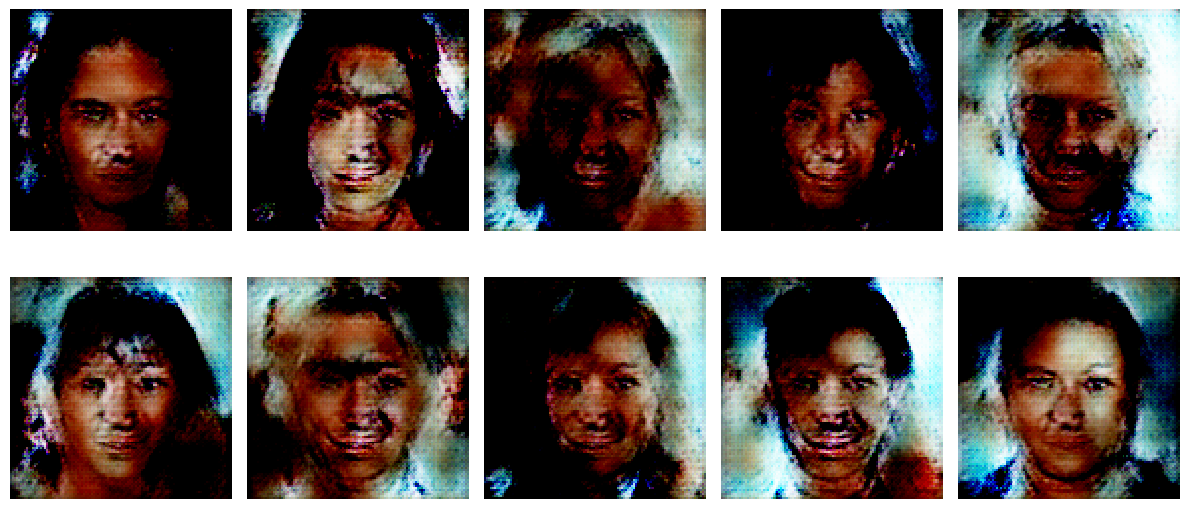

4/4 [==============================] - 0s 30ms/step
Epoch: 17, Batch: 1/74, D_Loss_Real=0.589, D_Loss_Fake=0.443 Gen_Loss=2.386
1/1 [==============================] - 0s 18ms/step


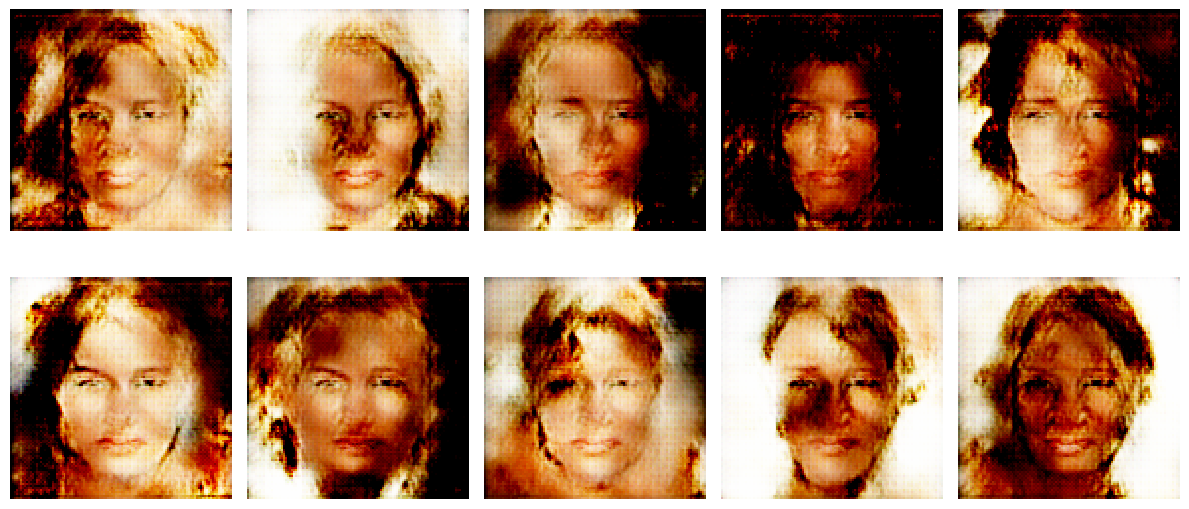

4/4 [==============================] - 0s 30ms/step
Epoch: 18, Batch: 1/74, D_Loss_Real=0.418, D_Loss_Fake=0.648 Gen_Loss=3.111
1/1 [==============================] - 0s 18ms/step


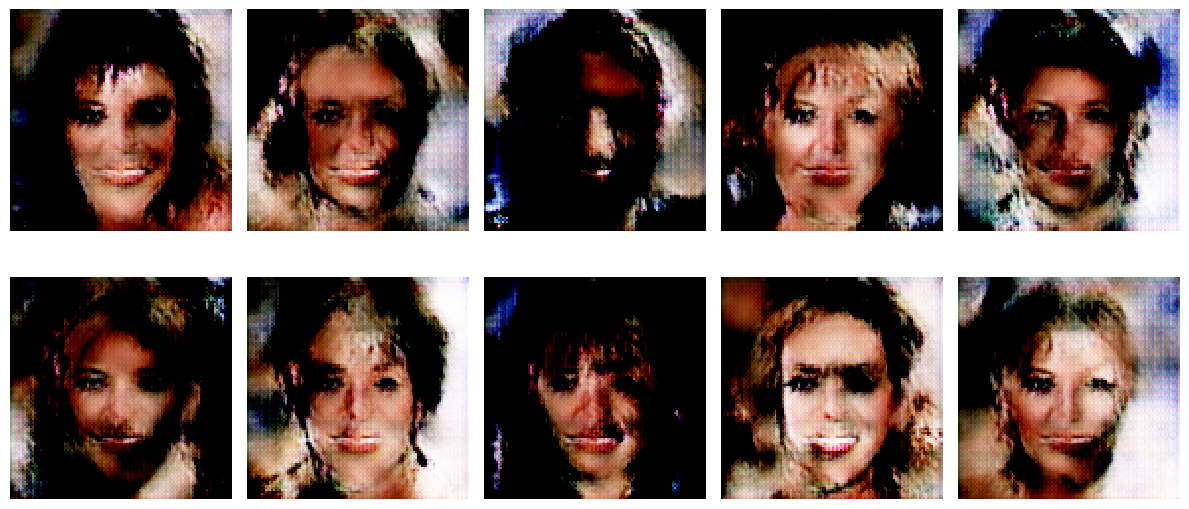

4/4 [==============================] - 0s 30ms/step
Epoch: 19, Batch: 1/74, D_Loss_Real=0.431, D_Loss_Fake=0.363 Gen_Loss=2.005
1/1 [==============================] - 0s 18ms/step


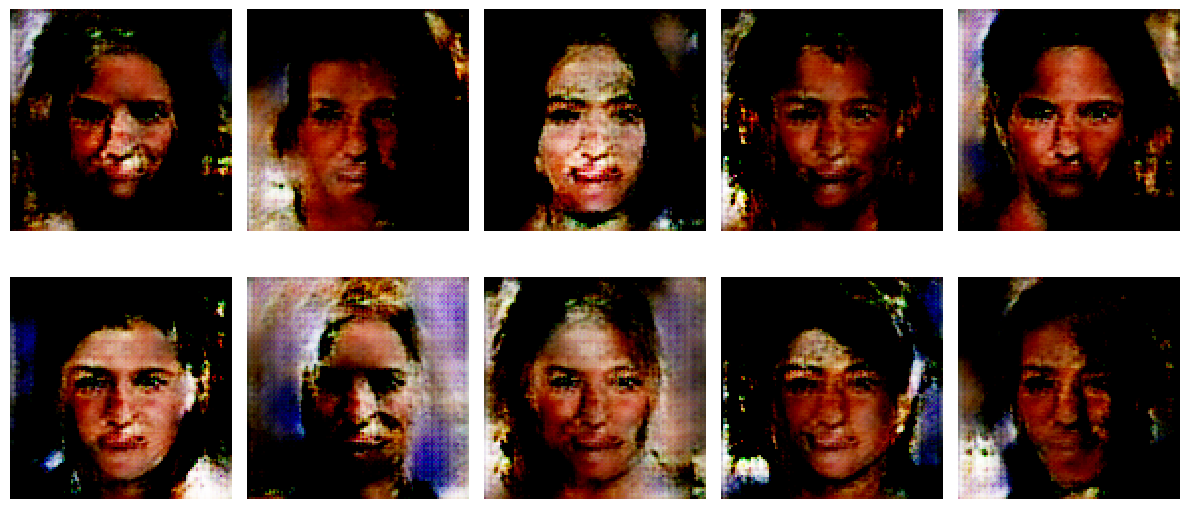

4/4 [==============================] - 0s 30ms/step
Epoch: 20, Batch: 1/74, D_Loss_Real=0.376, D_Loss_Fake=0.416 Gen_Loss=2.377
1/1 [==============================] - 0s 18ms/step


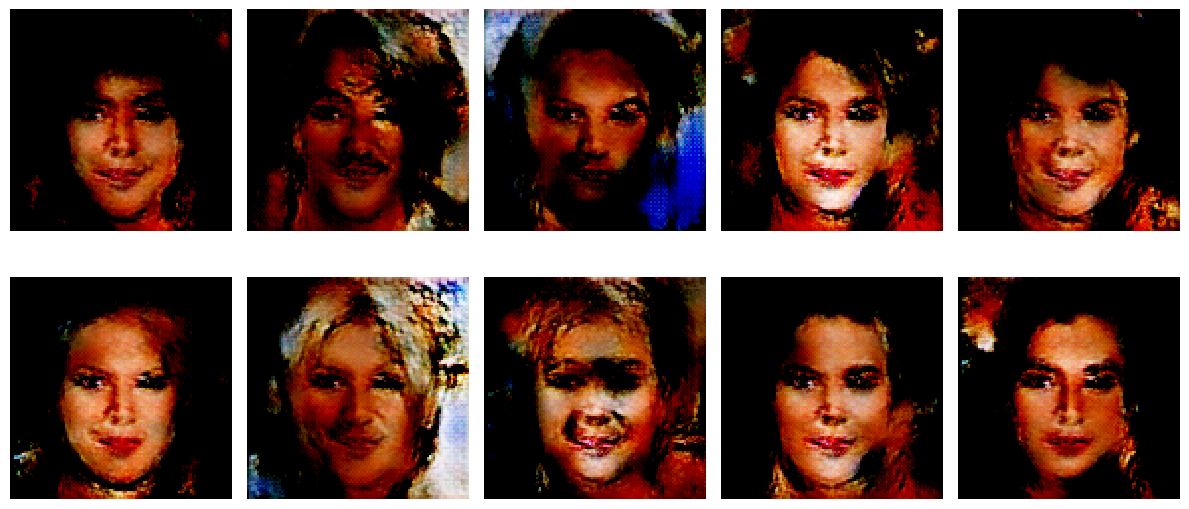

4/4 [==============================] - 0s 30ms/step


In [11]:
# training process of model
train(gen_model, dis_model, gan_model, dataset, latent_dim,20)

***SAVE GENERATOR MODEL***

In [15]:
# We need to compile the generator to avoid a warning. This is because we have previously only copiled within the larger cDCGAN model
gen_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.49))
# Save the Generator on your drive
gen_model.save('/kaggle/working/cgan_generator.h5')

***LOAD GENERATOR MODEL AND GENEATE IMAGES***

1/1 [==============================] - 0s 130ms/step


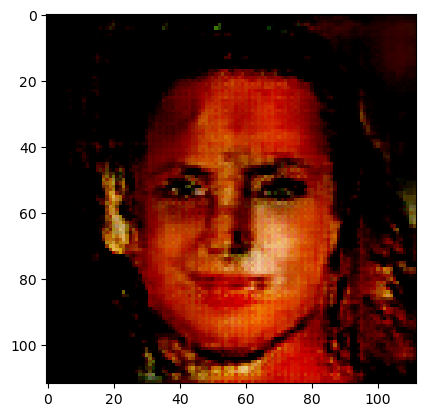

In [57]:
# Generate latent points
latent_points = latent_vector(100, 1)

# Specify labels that we want (0-9 repeated 10 times)
labels = np.asarray([0])

# Load previously saved generator model
model = load_model('/kaggle/working/cgan_generator.h5')

# Generate images
gen_imgs  = model.predict([latent_points])

# Scale from [-1, 1] to [0, 1]


img=gen_imgs[0]
plt.imshow(img)
plt.show()

In [17]:

.


SyntaxError: invalid syntax (1378382575.py, line 1)